# Reads assignment (classic segmentation)

2022-02-17

In [8]:
# Import packages 
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from natsort import natsorted
from scipy.io import loadmat, savemat
from skimage.filters import threshold_otsu
from skimage.color import label2rgb
from tqdm.notebook import tqdm

# Customized packages 
from starmap.sequencing import *

In [15]:
# Get functions 

from functools import wraps
from time import time

# Timer
def timer(func):
    @wraps(func)
    def _time_it(*args, **kwargs):
        start = int(round(time() * 1000))
        try:
            return func(*args, **kwargs)
        finally:
            end_ = int(round(time() * 1000)) - start
            end_ = round(end_ / 1000, 4)
            print(f"Total execution time: {end_ if end_ > 0 else 0} s")
    return _time_it


# Trim reads (archived)
@timer
def trim_reads(sample_dir, save_as=True):
    
    print(f"Trimming reads...")
    current_coordinates = np.loadtxt(os.path.join(sample_dir, 'trim.txt'), dtype=int, delimiter=',')
    current_dots = loadmat(os.path.join(sample_dir, 'merged_goodPoints_max3d.mat'))
    
    # Load reads from matlab data file
    bases = [str(i[0][0]) for i in current_dots["merged_reads"]]
    bases = np.array(bases)
    
    # Get reads location
    temp = current_dots["merged_points"]
    
    # Trim reads 
    to_remove = (temp[:, 0] < current_coordinates[0, 0]) | (temp[:, 0] > current_coordinates[1, 0]) | (temp[:, 1] < current_coordinates[0, 1]) | (temp[:, 1] > current_coordinates[1, 1])
    temp = temp[~to_remove, :]
    temp[:, 0] = temp[:, 0] - current_coordinates[0, 0]
    temp[:, 1] = temp[:, 1] - current_coordinates[0, 1]
    bases = bases[~to_remove]

    # Save trimmed reads
    if save_as:
        output_dict = {'trimmed_reads': bases, 'trimmed_points': temp}
        savemat(os.path.join(sample_dir, 'trimmed_goodPoints_max3d.mat'), output_dict)

    # Convert to 0 indexed and switch axis for python
    temp = temp[:, :2]
    points = np.zeros(temp.shape)
    points[:, 0] = np.round(temp[:, 1]-1)
    points[:, 1] = np.round(temp[:, 0]-1)
    print(f"Number of reads: {len(bases)}")
    
    return points, bases

# Trim reads (archived)
@timer
def load_reads(sample_dir):
    
    print(f"Loading reads...")
    current_dots = loadmat(os.path.join(sample_dir, 'trimmed_goodPoints_max3d.mat'))
    
    # Load reads from matlab data file
    bases = [str(i) for i in current_dots["trimmed_reads"]]
    bases = np.array(bases)
    
    # Get reads location
    temp = current_dots["trimmed_points"]
    
    # Convert to 0 indexed and switch axis for python
    temp = temp[:, :2]
    points = np.zeros(temp.shape)
    points[:, 0] = np.round(temp[:, 1]-1)
    points[:, 1] = np.round(temp[:, 0]-1)
    print(f"Number of reads: {len(bases)}")
    
    return points, bases

# Load code book (genes.csv)
def load_genes(base_path):
    genes2seqs = {}
    seqs2genes = {}
    with open(os.path.join(base_path, "genes.csv"), encoding='utf-8-sig') as f:
        for l in f:
            fields = l.rstrip().split(",")
            curr_seg = "".join([str(s+1) for s in encode_SOLID(fields[1][::-1])])
            curr_seg = curr_seg[5:] + curr_seg[:4]
            # print(curr_seg)
            genes2seqs[fields[0]] = curr_seg
            seqs2genes[genes2seqs[fields[0]]] = fields[0]
            
    return genes2seqs, seqs2genes

## Setup

In [3]:
# IO path 
base_path = 'Z:/Data/Analyzed/2022-01-03-Hu-AD/'
out_path = os.path.join(base_path, 'output')
if not os.path.exists(out_path):
    os.mkdir(out_path)
    
sample_dirs = [d for d in os.listdir(base_path) if "AD" in d]
sample_dirs

['13months_control-ADmouse_11351',
 '13months_control-ADmouse_9498',
 '13months_disease-ADmouse_11346',
 '13months_disease-ADmouse_9494',
 '8months_control-ADmouse_9707',
 '8months_control-ADmouse_9735',
 '8months_disease-ADmouse_9723',
 '8months_disease-ADmouse_9723_2']

## Run pipeline for individual sample

### Input

In [55]:
# Iterate through each sample dir
current_dir = sample_dirs[3]
print(f"Current sample: {current_dir}")

# Load reads 
points, bases = load_reads(os.path.join(base_path, current_dir))

# Load genes
genes2seqs, seqs2genes = load_genes(base_path)

# Load 2D overlay image 
overlay = load_nissl_image(os.path.join(base_path, current_dir, 'segmentation'), fname="overlay.tif")

# Load pi segmentation (pi_label.tif)
pi_label = load_label_image(os.path.join(base_path, current_dir, 'segmentation'), fname='pi_label.tif')
pi_label.shape

# Get cell locations 
centroids = []
areas = []
for i, region in enumerate(regionprops(pi_label)):
    centroids.append(region.centroid)
    areas.append(region.area)
    
centroids = np.array(centroids)
areas = np.array(areas)

Current sample: 8months_disease-ADmouse_9723_2
Loading reads...
Number of reads: 3477832
Total execution time: 25.103 s


C:\Users\jiahao\.conda\envs\bio38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


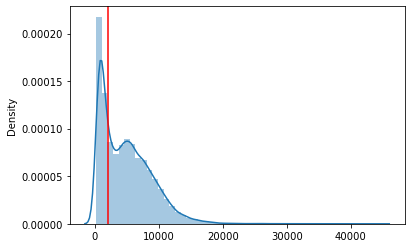

In [56]:
# Plot threshold to centroids based on area
area_threshold = 2000
sns.distplot(areas)
plt.axvline(area_threshold, c='r')
plt.show()

13months_control-ADmouse_10351: 2000

13months_disease-ADmouse_10346: 2000

8months_control-ADmouse_9707: 2000

8months_disease-ADmouse_9723_2: 2000

In [57]:
# Apply threshold to centroids based on area
to_keep = areas > area_threshold
centroids = centroids[to_keep, :]

### Segmentation

Gaussian & Thresholding


C:\Users\jiahao\.conda\envs\bio38\lib\site-packages\skimage\morphology\misc.py:39: FutureWarning: `selem` is a deprecated argument name for `binary_dilation`. It will be removed in version 1.0.Please use `footprint` instead.
  return func(image, footprint=footprint, *args, **kwargs)


Assigning markers
Watershed
Labeled 9682 cells
Saving files to Z:/Data/Analyzed/2022-01-03-Hu-AD/8months_disease-ADmouse_9723_2\segmentation
Wall time: 12min 32s


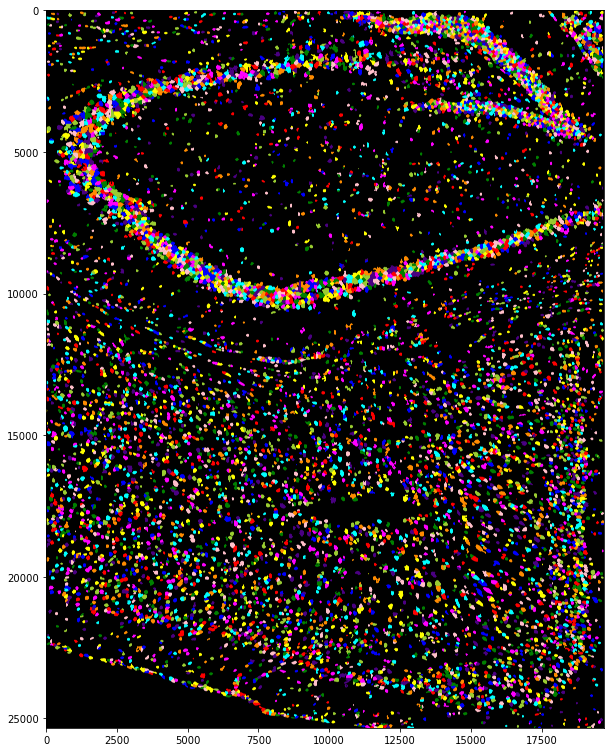

In [58]:
%%time
# Segmentation
seg_out_path = os.path.join(base_path, current_dir, 'segmentation')
if not os.path.exists(seg_out_path):
    os.mkdir(seg_out_path)

print("Gaussian & Thresholding")
blurred_overlay_seg = gaussian(overlay.astype(np.float), 10)
threhold = threshold_otsu(blurred_overlay_seg)

# otsu threshold 
blurred_overlay_seg = blurred_overlay_seg > threhold

# manual treshold 
# blurred_overlay_seg = gaussian(overlay.astype(np.float), 10) > 50

# dialation  
blurred_overlay_seg = binary_dilation(blurred_overlay_seg, selem=disk(10))

print("Assigning markers")
centroids = centroids.astype(int)
markers = np.zeros(blurred_overlay_seg.shape, dtype=np.uint8)
for i in range(centroids.shape[0]):
    x, y = centroids[i, :]
    if x < blurred_overlay_seg.shape[0] and y < blurred_overlay_seg.shape[1]:
        markers[x-1, y-1] = 1
markers = ndi.label(markers)[0]

print("Watershed")
labels = watershed(blurred_overlay_seg, markers, mask=blurred_overlay_seg)
labels_line = watershed(blurred_overlay_seg, markers, mask=blurred_overlay_seg, watershed_line=True)

print(f"Labeled {len(np.unique(labels)) - 1} cells")
plt.figure(figsize=(10,20))
plt.imshow(label2rgb(labels_line))

print(f"Saving files to {seg_out_path}")
tifffile.imsave(os.path.join(seg_out_path, "labeled_cells_line.tif"), labels_line.astype(np.uint16))
tifffile.imsave(os.path.join(seg_out_path, "labeled_cells.tif"), labels.astype(np.uint16))

In [59]:
# Set figure size 
figsize=(labels_line.shape[1] / 1000 * 5, labels_line.shape[0] / 1000 * 5)

# Plot cell number 
t_size = 10
plt.figure(figsize=figsize)
plt.imshow(overlay)
for i, region in enumerate(regionprops(labels_line)):
    plt.plot(region.centroid[1], region.centroid[0], '.', color='red', markersize=4)
    plt.text(region.centroid[1], region.centroid[0], str(i), fontsize=t_size, color='red')

plt.axis('off')
plt.savefig(os.path.join(seg_out_path, "cell_nums.png"))
plt.clf()
plt.close()

In [60]:
# Plot dots on segmentation mask
plt.figure(figsize=figsize)
plt.imshow(labels_line > 0, cmap='gray')
plt.plot(points[:, 1], points[:, 0], '.', color='red', markersize=1)
plt.axis('off')
points_seg_path = os.path.join(seg_out_path, "points_seg.png")
print(f"Saving points_seg.png")
plt.savefig(points_seg_path)
plt.clf()
plt.close()

Saving points_seg.png


In [61]:
# Plot dots on overlay
plt.figure(figsize=figsize)
plt.imshow(overlay, cmap='gray')
plt.plot(points[:, 1], points[:, 0], '.', color='red', markersize=1)
plt.axis('off')
points_seg_path = os.path.join(seg_out_path, "points_overlay.png")
print(f"Saving points_overlay.png")
plt.savefig(points_seg_path)
plt.clf()
plt.close()

Saving points_overlay.png


### Reads assignment

In [62]:
%%time
# Reads assignment to cell
expr_out_path = os.path.join(out_path, current_dir)
if not os.path.exists(expr_out_path):
    os.mkdir(expr_out_path)
        
points = points.astype(int)
reads_assignment = labels[points[:, 0], points[:, 1]]
    
cell_locs = []
total_cells = len(np.unique(labels)) - 1
areas = []

gene_seqs = seqs2genes.keys()
cell_by_barcode = np.zeros((total_cells, len(gene_seqs)))
gene_seq_to_index = {}  # map from sequence to index into matrix

for i, k in enumerate(gene_seqs):
    gene_seq_to_index[k] = i
    
# Iterate through cells
print('Iterate cells...')
for i, region in enumerate(regionprops(labels)):
    # print(region.label)
    areas.append(region.area)
    cell_locs.append(region.centroid)
    
    assigned_reads = bases[np.argwhere(reads_assignment == region.label).flatten()]
    for j in assigned_reads:
        if j in gene_seq_to_index:
            cell_by_barcode[i, gene_seq_to_index[j]] += 1
    
     
# Construct output
cell_locs = np.array(cell_locs).astype(int)
curr_meta = pd.DataFrame({'sample': current_dir, 'area': areas,
                          'x':cell_locs[:, 1], 'y':cell_locs[:, 0]})

with open(os.path.join(expr_out_path, "log.txt"), 'w') as f:
    msg = "{:.2%} percent [{} out of {}] reads were assigned to {} cells".format(cell_by_barcode.sum()/len(bases), cell_by_barcode.sum(), len(bases), total_cells)
    print(msg)
    f.write(msg)
np.savetxt(os.path.join(expr_out_path, "cell_barcode_count.csv"), cell_by_barcode.astype(np.int), delimiter=',', fmt="%d")
cell_barcode_names = pd.DataFrame({'seq': list(seqs2genes.keys()), 'gene': list(seqs2genes.values())})
cell_barcode_names.to_csv(os.path.join(expr_out_path, "cell_barcode_names.csv"), header=False)
curr_meta.to_csv(os.path.join(expr_out_path, "meta.csv"))

Iterate cells...
51.08% percent [1776624.0 out of 3477832] reads were assigned to 9682 cells
Wall time: 1min 34s


In [63]:
# Preview current metadata
curr_meta.head()

,sample,area,x,y
0,8months_disease-ADmouse_9723_2,5687,2466,61
1,8months_disease-ADmouse_9723_2,5885,8403,59
2,8months_disease-ADmouse_9723_2,9398,18699,59
3,8months_disease-ADmouse_9723_2,5382,14785,66
4,8months_disease-ADmouse_9723_2,2184,11377,54


C:\Users\jiahao\.conda\envs\bio38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

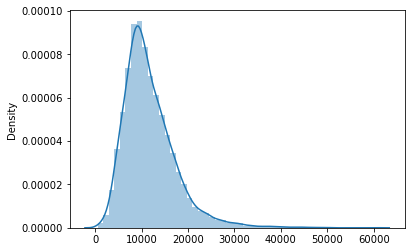

In [64]:
# Plot area distribution
sns.distplot(areas)

### Reads pattern visualization

In [ ]:
# Get assigned reads 
assigned_index = np.argwhere(reads_assignment != 0).flatten()
assigned_bases = bases[assigned_index]
assigned_points = points[assigned_index, :]

In [ ]:
# Get reads of specific gene
gene = 'PPP1R9B'
curr_index = np.argwhere(assigned_bases == genes2seqs[gene]).flatten()
curr_points = assigned_points[curr_index, :]
print(f"Number of reads: {curr_points.shape[0]}")

In [ ]:
# Plot dots on segmentation mask
plt.figure(figsize=figsize)
plt.imshow(nissl, cmap='gray')
plt.plot(curr_points[:, 1], curr_points[:, 0], '.', color='red', markersize=1)
plt.axis('off')
plt.show()

In [ ]:
# Get read quantification for each gene after read assignemnt and got the top-20
per_gene_expr = pd.DataFrame({'gene': list(seqs2genes.values()), 'expr': cell_by_barcode.sum(axis=0)})
per_gene_expr = per_gene_expr.sort_values('expr', ascending=False, ignore_index=True)

# Get top 20 genes & Curated markers 
top20 = per_gene_expr.head(20).gene.to_list()
curated = ['SLC17A7', 'CUX2', 'RORB', 'SULF2', 'PCP4',
          'GAD1', 'PVALB', 'SST', 'NPY', 'VIP', 'MBP', 'MOBP']
selected_genes = top20 + curated
selected_genes

In [ ]:
# Generate reads pattern plot for all the selected genes 
expr_figure_out_path = os.path.join(expr_out_path, 'figures')
if not os.path.exists(expr_figure_out_path):
    os.mkdir(expr_figure_out_path)
    
for i, gene in enumerate(selected_genes):
    
    curr_index = np.argwhere(assigned_bases == genes2seqs[gene]).flatten()
    curr_points = assigned_points[curr_index, :]
    n_reads = curr_points.shape[0]

    # Plot
    plt.figure(figsize=figsize)
    plt.imshow(nissl, cmap='gray')
    plt.plot(curr_points[:, 1], curr_points[:, 0], '.', color='red', markersize=1)
    plt.axis('off')
    expr_figure_path = os.path.join(expr_figure_out_path, f"{i+1}.{gene}_{n_reads}.png")
    plt.savefig(expr_figure_path)
    plt.clf()
    plt.close()

## Generate complete matrix

*run this after finishing assignments for all samples*

In [65]:
# Construct complete matrix
cell_by_gene_complete = None
meta_complete = None

for i, d in enumerate(sample_dirs):
    print(f"Loading sample: {d}")
    current_expr_path = os.path.join(out_path, d)
    current_expr = np.loadtxt(os.path.join(current_expr_path, "cell_barcode_count.csv"), dtype=int, delimiter=',')
    current_meta = pd.read_csv(os.path.join(current_expr_path, "meta.csv"))
    
    # add to complete matrix
    if cell_by_gene_complete is not None:
        cell_by_gene_complete = np.concatenate((cell_by_gene_complete, current_expr))
    else:
        cell_by_gene_complete = current_expr
        
    if meta_complete is not None:
        meta_complete = pd.concat([meta_complete, current_meta])
    else:
        meta_complete = current_meta
        
np.savetxt(os.path.join(out_path, "complete_cell_barcode_count.csv"), cell_by_gene_complete.astype(np.int), delimiter=',', fmt="%d")
meta_complete = meta_complete.reset_index(drop=True)
meta_complete = meta_complete.rename(columns={"Unnamed: 0": "orig_index"})
meta_complete.to_csv(os.path.join(out_path, "complete_meta.csv"))

Loading sample: 13months_control-ADmouse_10351
Loading sample: 13months_disease-ADmouse_10346
Loading sample: 8months_control-ADmouse_9707
Loading sample: 8months_disease-ADmouse_9723_2


## Batch process

In [5]:
# IO path 
base_path = 'Z:/Data/Analyzed/2022-01-03-Hu-AD/'
out_path = os.path.join(base_path, 'output')
if not os.path.exists(out_path):
    os.mkdir(out_path)
    
sample_dirs = [d for d in os.listdir(base_path) if "AD" in d]
sample_dirs

['13months_control-ADmouse_11351',
 '13months_control-ADmouse_9498',
 '13months_disease-ADmouse_11346',
 '13months_disease-ADmouse_9494',
 '8months_control-ADmouse_9707',
 '8months_control-ADmouse_9735',
 '8months_disease-ADmouse_9723',
 '8months_disease-ADmouse_9723_2']

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\jiahao\.conda\envs\bio38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


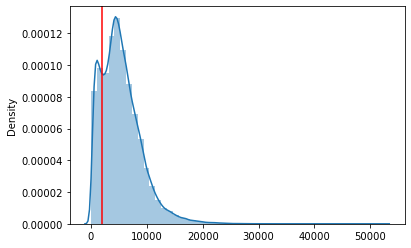

In [9]:
from tqdm.notebook import tqdm

## Get area threshold
# sample_dirs = sample_dirs[:1]

areas = []
for current_dir in tqdm(sample_dirs):
    ######## Iterate through each sample dir
 
    # Load pi segmentation (pi_label.tif)
    pi_label = load_label_image(os.path.join(base_path, current_dir, 'segmentation'), fname='pi_label.tif')
    pi_label.shape

    # Get cell locations 
    for i, region in enumerate(regionprops(pi_label)):
        areas.append(region.area)

    

# Plot threshold to centroids based on area
area_threshold = 2000
areas = np.array(areas)
sns.distplot(areas)
plt.axvline(area_threshold, c='r')
plt.show()

  0%|          | 0/8 [00:00<?, ?it/s]

Current sample: 13months_control-ADmouse_11351
Loading reads...
Number of reads: 3236375
Total execution time: 22.428 s


C:\Users\jiahao\.conda\envs\bio38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Gaussian & Thresholding


C:\Users\jiahao\.conda\envs\bio38\lib\site-packages\skimage\morphology\misc.py:39: FutureWarning: `selem` is a deprecated argument name for `binary_dilation`. It will be removed in version 1.0.Please use `footprint` instead.
  return func(image, footprint=footprint, *args, **kwargs)


Assigning markers
Watershed
Labeled 10803 cells
Saving files to Z:/Data/Analyzed/2022-01-03-Hu-AD/13months_control-ADmouse_11351\segmentation
Saving points_seg.png
Saving points_overlay.png
Iterate cells...
44.92% percent [1453672.0 out of 3236375] reads were assigned to 10803 cells
Current sample: 13months_control-ADmouse_9498
Loading reads...
Number of reads: 3829199
Total execution time: 26.458 s


C:\Users\jiahao\.conda\envs\bio38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Gaussian & Thresholding


C:\Users\jiahao\.conda\envs\bio38\lib\site-packages\skimage\morphology\misc.py:39: FutureWarning: `selem` is a deprecated argument name for `binary_dilation`. It will be removed in version 1.0.Please use `footprint` instead.
  return func(image, footprint=footprint, *args, **kwargs)


Assigning markers
Watershed
Labeled 10419 cells
Saving files to Z:/Data/Analyzed/2022-01-03-Hu-AD/13months_control-ADmouse_9498\segmentation
Saving points_seg.png
Saving points_overlay.png
Iterate cells...
52.33% percent [2003933.0 out of 3829199] reads were assigned to 10419 cells
Current sample: 13months_disease-ADmouse_11346
Loading reads...
Number of reads: 3680030
Total execution time: 25.789 s


C:\Users\jiahao\.conda\envs\bio38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Gaussian & Thresholding


C:\Users\jiahao\.conda\envs\bio38\lib\site-packages\skimage\morphology\misc.py:39: FutureWarning: `selem` is a deprecated argument name for `binary_dilation`. It will be removed in version 1.0.Please use `footprint` instead.
  return func(image, footprint=footprint, *args, **kwargs)


Assigning markers
Watershed
Labeled 10217 cells
Saving files to Z:/Data/Analyzed/2022-01-03-Hu-AD/13months_disease-ADmouse_11346\segmentation
Saving points_seg.png
Saving points_overlay.png
Iterate cells...
47.89% percent [1762454.0 out of 3680030] reads were assigned to 10217 cells
Current sample: 13months_disease-ADmouse_9494
Loading reads...
Number of reads: 6748247
Total execution time: 47.037 s


C:\Users\jiahao\.conda\envs\bio38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Gaussian & Thresholding


C:\Users\jiahao\.conda\envs\bio38\lib\site-packages\skimage\morphology\misc.py:39: FutureWarning: `selem` is a deprecated argument name for `binary_dilation`. It will be removed in version 1.0.Please use `footprint` instead.
  return func(image, footprint=footprint, *args, **kwargs)


Assigning markers
Watershed
Labeled 10048 cells
Saving files to Z:/Data/Analyzed/2022-01-03-Hu-AD/13months_disease-ADmouse_9494\segmentation
Saving points_seg.png
Saving points_overlay.png
Iterate cells...
46.38% percent [3129987.0 out of 6748247] reads were assigned to 10048 cells
Current sample: 8months_control-ADmouse_9707
Loading reads...
Number of reads: 4121402
Total execution time: 28.782 s


C:\Users\jiahao\.conda\envs\bio38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Gaussian & Thresholding


C:\Users\jiahao\.conda\envs\bio38\lib\site-packages\skimage\morphology\misc.py:39: FutureWarning: `selem` is a deprecated argument name for `binary_dilation`. It will be removed in version 1.0.Please use `footprint` instead.
  return func(image, footprint=footprint, *args, **kwargs)


Assigning markers
Watershed
Labeled 10121 cells
Saving files to Z:/Data/Analyzed/2022-01-03-Hu-AD/8months_control-ADmouse_9707\segmentation
Saving points_seg.png
Saving points_overlay.png
Iterate cells...
50.89% percent [2097423.0 out of 4121402] reads were assigned to 10121 cells
Current sample: 8months_control-ADmouse_9735
Loading reads...
Number of reads: 5089792
Total execution time: 36.039 s


C:\Users\jiahao\.conda\envs\bio38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Gaussian & Thresholding


C:\Users\jiahao\.conda\envs\bio38\lib\site-packages\skimage\morphology\misc.py:39: FutureWarning: `selem` is a deprecated argument name for `binary_dilation`. It will be removed in version 1.0.Please use `footprint` instead.
  return func(image, footprint=footprint, *args, **kwargs)


Assigning markers
Watershed
Labeled 8523 cells
Saving files to Z:/Data/Analyzed/2022-01-03-Hu-AD/8months_control-ADmouse_9735\segmentation
Saving points_seg.png
Saving points_overlay.png
Iterate cells...
45.34% percent [2307774.0 out of 5089792] reads were assigned to 8523 cells
Current sample: 8months_disease-ADmouse_9723
Loading reads...
Number of reads: 2404917
Total execution time: 17.029 s


C:\Users\jiahao\.conda\envs\bio38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Gaussian & Thresholding


C:\Users\jiahao\.conda\envs\bio38\lib\site-packages\skimage\morphology\misc.py:39: FutureWarning: `selem` is a deprecated argument name for `binary_dilation`. It will be removed in version 1.0.Please use `footprint` instead.
  return func(image, footprint=footprint, *args, **kwargs)


Assigning markers
Watershed
Labeled 8434 cells
Saving files to Z:/Data/Analyzed/2022-01-03-Hu-AD/8months_disease-ADmouse_9723\segmentation
Saving points_seg.png
Saving points_overlay.png
Iterate cells...
54.76% percent [1316870.0 out of 2404917] reads were assigned to 8434 cells
Current sample: 8months_disease-ADmouse_9723_2
Loading reads...
Number of reads: 3477832
Total execution time: 25.196 s


C:\Users\jiahao\.conda\envs\bio38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Gaussian & Thresholding


C:\Users\jiahao\.conda\envs\bio38\lib\site-packages\skimage\morphology\misc.py:39: FutureWarning: `selem` is a deprecated argument name for `binary_dilation`. It will be removed in version 1.0.Please use `footprint` instead.
  return func(image, footprint=footprint, *args, **kwargs)


Assigning markers
Watershed
Labeled 8639 cells
Saving files to Z:/Data/Analyzed/2022-01-03-Hu-AD/8months_disease-ADmouse_9723_2\segmentation
Saving points_seg.png
Saving points_overlay.png
Iterate cells...
49.80% percent [1732026.0 out of 3477832] reads were assigned to 8639 cells


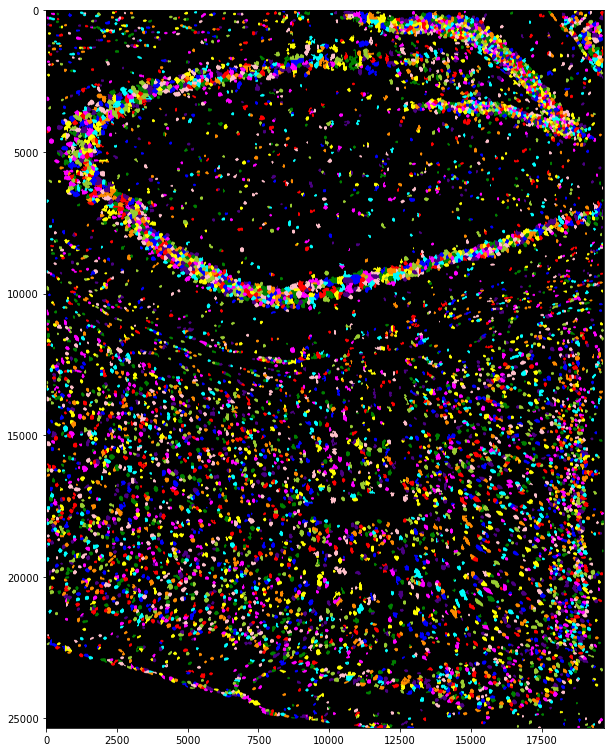

In [10]:
# IO path 
base_path = 'Z:/Data/Analyzed/2022-01-03-Hu-AD/'
out_path = os.path.join(base_path, 'output')
if not os.path.exists(out_path):
    os.mkdir(out_path)
    
sample_dirs = [d for d in os.listdir(base_path) if "AD" in d]
# sample_dirs = sample_dirs[:1]

for current_dir in tqdm(sample_dirs):
    ######## Iterate through each sample dir
    print(f"Current sample: {current_dir}")

    # Load reads 
    points, bases = load_reads(os.path.join(base_path, current_dir))

    # Load genes
    genes2seqs, seqs2genes = load_genes(base_path)

    # Load 2D overlay image 
    overlay = load_nissl_image(os.path.join(base_path, current_dir, 'segmentation'), fname="overlay.tif")

    # Load pi segmentation (pi_label.tif)
    pi_label = load_label_image(os.path.join(base_path, current_dir, 'segmentation'), fname='pi_label.tif')
    pi_label.shape

    # Get cell locations 
    centroids = []
    areas = []
    for i, region in enumerate(regionprops(pi_label)):
        centroids.append(region.centroid)
        areas.append(region.area)

    centroids = np.array(centroids)
    areas = np.array(areas)
    
    ######## Segmentation
    seg_out_path = os.path.join(base_path, current_dir, 'segmentation')
    if not os.path.exists(seg_out_path):
        os.mkdir(seg_out_path)

    # Plot threshold to centroids based on area
    area_threshold = 2000
    plt.figure()
    sns.distplot(areas)
    plt.axvline(area_threshold, c='r')
    plt.savefig(os.path.join(seg_out_path, "pi_label_threshold.png"))
    plt.clf()
    plt.close()
    
    
    ######## Apply threshold to centroids based on area
    to_keep = areas > area_threshold
    centroids = centroids[to_keep, :]
    
    print("Gaussian & Thresholding")
    blurred_overlay_seg = gaussian(overlay.astype(np.float), 10)
    threhold = threshold_otsu(blurred_overlay_seg)

    # otsu threshold 
    blurred_overlay_seg = blurred_overlay_seg > threhold

    # manual treshold 
    # blurred_overlay_seg = gaussian(overlay.astype(np.float), 10) > 50

    # dialation  
    blurred_overlay_seg = binary_dilation(blurred_overlay_seg, selem=disk(10))

    print("Assigning markers")
    centroids = centroids.astype(int)
    markers = np.zeros(blurred_overlay_seg.shape, dtype=np.uint8)
    for i in range(centroids.shape[0]):
        x, y = centroids[i, :]
        if x < blurred_overlay_seg.shape[0] and y < blurred_overlay_seg.shape[1]:
            markers[x-1, y-1] = 1
    markers = ndi.label(markers)[0]

    print("Watershed")
    labels = watershed(blurred_overlay_seg, markers, mask=blurred_overlay_seg)
    labels_line = watershed(blurred_overlay_seg, markers, mask=blurred_overlay_seg, watershed_line=True)

    print(f"Labeled {len(np.unique(labels)) - 1} cells")
    plt.figure(figsize=(10,20))
    plt.imshow(label2rgb(labels_line))

    print(f"Saving files to {seg_out_path}")
    tifffile.imsave(os.path.join(seg_out_path, "labeled_cells_line.tif"), labels_line.astype(np.uint16))
    tifffile.imsave(os.path.join(seg_out_path, "labeled_cells.tif"), labels.astype(np.uint16))

    ######## Set figure size 
    figsize=(labels_line.shape[1] / 1000 * 5, labels_line.shape[0] / 1000 * 5)

    # Plot cell number 
    t_size = 10
    plt.figure(figsize=figsize)
    plt.imshow(overlay)
    for i, region in enumerate(regionprops(labels_line)):
        plt.plot(region.centroid[1], region.centroid[0], '.', color='red', markersize=4)
        plt.text(region.centroid[1], region.centroid[0], str(i), fontsize=t_size, color='red')

    plt.axis('off')
    plt.savefig(os.path.join(seg_out_path, "cell_nums.png"))
    plt.clf()
    plt.close()
    
    # Plot dots on segmentation mask
    plt.figure(figsize=figsize)
    plt.imshow(labels_line > 0, cmap='gray')
    plt.plot(points[:, 1], points[:, 0], '.', color='red', markersize=1)
    plt.axis('off')
    points_seg_path = os.path.join(seg_out_path, "points_seg.png")
    print(f"Saving points_seg.png")
    plt.savefig(points_seg_path)
    plt.clf()
    plt.close()
    
    # Plot dots on overlay
    plt.figure(figsize=figsize)
    plt.imshow(overlay, cmap='gray')
    plt.plot(points[:, 1], points[:, 0], '.', color='red', markersize=1)
    plt.axis('off')
    points_seg_path = os.path.join(seg_out_path, "points_overlay.png")
    print(f"Saving points_overlay.png")
    plt.savefig(points_seg_path)
    plt.clf()
    plt.close()

    
    ######## Reads assignment to cell
    expr_out_path = os.path.join(out_path, current_dir)
    if not os.path.exists(expr_out_path):
        os.mkdir(expr_out_path)

    points = points.astype(int)
    reads_assignment = labels[points[:, 0], points[:, 1]]

    cell_locs = []
    total_cells = len(np.unique(labels)) - 1
    areas = []

    gene_seqs = seqs2genes.keys()
    cell_by_barcode = np.zeros((total_cells, len(gene_seqs)))
    gene_seq_to_index = {}  # map from sequence to index into matrix

    for i, k in enumerate(gene_seqs):
        gene_seq_to_index[k] = i

    # Iterate through cells
    print('Iterate cells...')
    for i, region in enumerate(regionprops(labels)):
        # print(region.label)
        areas.append(region.area)
        cell_locs.append(region.centroid)

        assigned_reads = bases[np.argwhere(reads_assignment == region.label).flatten()]
        for j in assigned_reads:
            if j in gene_seq_to_index:
                cell_by_barcode[i, gene_seq_to_index[j]] += 1


    # Construct output
    cell_locs = np.array(cell_locs).astype(int)
    curr_meta = pd.DataFrame({'sample': current_dir, 'area': areas,
                              'x':cell_locs[:, 1], 'y':cell_locs[:, 0]})

    with open(os.path.join(expr_out_path, "log.txt"), 'w') as f:
        msg = "{:.2%} percent [{} out of {}] reads were assigned to {} cells".format(cell_by_barcode.sum()/len(bases), cell_by_barcode.sum(), len(bases), total_cells)
        print(msg)
        f.write(msg)
    np.savetxt(os.path.join(expr_out_path, "cell_barcode_count.csv"), cell_by_barcode.astype(np.int), delimiter=',', fmt="%d")
    cell_barcode_names = pd.DataFrame({'seq': list(seqs2genes.keys()), 'gene': list(seqs2genes.values())})
    cell_barcode_names.to_csv(os.path.join(expr_out_path, "cell_barcode_names.csv"), header=False)
    curr_meta.to_csv(os.path.join(expr_out_path, "meta.csv"))

### Generate complete matrix

*run this after finishing assignments for all samples*

In [7]:
# Construct complete matrix
cell_by_gene_complete = None
meta_complete = None

for i, d in enumerate(sample_dirs):
    print(f"Loading sample: {d}")
    current_expr_path = os.path.join(out_path, d)
    current_expr = np.loadtxt(os.path.join(current_expr_path, "cell_barcode_count.csv"), dtype=int, delimiter=',')
    current_meta = pd.read_csv(os.path.join(current_expr_path, "meta.csv"))
    
    # add to complete matrix
    if cell_by_gene_complete is not None:
        cell_by_gene_complete = np.concatenate((cell_by_gene_complete, current_expr))
    else:
        cell_by_gene_complete = current_expr
        
    if meta_complete is not None:
        meta_complete = pd.concat([meta_complete, current_meta])
    else:
        meta_complete = current_meta
        
np.savetxt(os.path.join(out_path, "complete_cell_barcode_count.csv"), cell_by_gene_complete.astype(np.int), delimiter=',', fmt="%d")
meta_complete = meta_complete.reset_index(drop=True)
meta_complete = meta_complete.rename(columns={"Unnamed: 0": "orig_index"})
meta_complete.to_csv(os.path.join(out_path, "complete_meta.csv"))

Loading sample: 13months_control-ADmouse_11351
Loading sample: 13months_control-ADmouse_9498
Loading sample: 13months_disease-ADmouse_11346
Loading sample: 13months_disease-ADmouse_9494
Loading sample: 8months_control-ADmouse_9707
Loading sample: 8months_control-ADmouse_9735
Loading sample: 8months_disease-ADmouse_9723
Loading sample: 8months_disease-ADmouse_9723_2


## Batch process (reads assignment only)

In [21]:
# IO path 
base_path = 'Z:/Data/Analyzed/2022-01-03-Hu-AD/'
out_path = os.path.join(base_path, 'output')
if not os.path.exists(out_path):
    os.mkdir(out_path)
    
sample_dirs = [d for d in os.listdir(base_path) if "AD" in d]
sample_dirs

['13months_control-ADmouse_11351',
 '13months_control-ADmouse_9498',
 '13months_disease-ADmouse_11346',
 '13months_disease-ADmouse_9494',
 '8months_control-ADmouse_9707',
 '8months_control-ADmouse_9735',
 '8months_disease-ADmouse_9723',
 '8months_disease-ADmouse_9723_2']

In [19]:
# new replicates only
sample_dirs = ['13months_control-ADmouse_11351',
             '13months_disease-ADmouse_11346',
             '8months_control-ADmouse_9707',
             '8months_disease-ADmouse_9723_2']

In [20]:
for current_dir in tqdm(sample_dirs):
    ######## Iterate through each sample dir
    print(f"Current sample: {current_dir}")

    # Load reads 
    points, bases = load_reads(os.path.join(base_path, current_dir))

    # Load genes
    genes2seqs, seqs2genes = load_genes(base_path)

    # Load cell segmentation
    labels = load_label_image(os.path.join(base_path, current_dir, 'segmentation'), fname='labeled_cells.tif')
    labels.shape

    ######## Reads assignment to cell
    expr_out_path = os.path.join(out_path, current_dir)
    if not os.path.exists(expr_out_path):
        os.mkdir(expr_out_path)

    points = points.astype(int)
    reads_assignment = labels[points[:, 0], points[:, 1]]

    cell_locs = []
    total_cells = len(np.unique(labels)) - 1
    areas = []

    gene_seqs = seqs2genes.keys()
    cell_by_barcode = np.zeros((total_cells, len(gene_seqs)))
    gene_seq_to_index = {}  # map from sequence to index into matrix

    for i, k in enumerate(gene_seqs):
        gene_seq_to_index[k] = i

    # Iterate through cells
    print('Iterate cells...')
    for i, region in enumerate(regionprops(labels)):
        # print(region.label)
        areas.append(region.area)
        cell_locs.append(region.centroid)

        assigned_reads = bases[np.argwhere(reads_assignment == region.label).flatten()]
        for j in assigned_reads:
            if j in gene_seq_to_index:
                cell_by_barcode[i, gene_seq_to_index[j]] += 1


    # Construct output
    cell_locs = np.array(cell_locs).astype(int)
    curr_meta = pd.DataFrame({'sample': current_dir, 'area': areas,
                              'x':cell_locs[:, 1], 'y':cell_locs[:, 0]})

    with open(os.path.join(expr_out_path, "log.txt"), 'w') as f:
        msg = "{:.2%} percent [{} out of {}] reads were assigned to {} cells".format(cell_by_barcode.sum()/len(bases), cell_by_barcode.sum(), len(bases), total_cells)
        print(msg)
        f.write(msg)
    np.savetxt(os.path.join(expr_out_path, "cell_barcode_count.csv"), cell_by_barcode.astype(np.int), delimiter=',', fmt="%d")
    cell_barcode_names = pd.DataFrame({'seq': list(seqs2genes.keys()), 'gene': list(seqs2genes.values())})
    cell_barcode_names.to_csv(os.path.join(expr_out_path, "cell_barcode_names.csv"), header=False)
    curr_meta.to_csv(os.path.join(expr_out_path, "meta.csv"))

  0%|          | 0/4 [00:00<?, ?it/s]

Current sample: 13months_control-ADmouse_11351
Loading reads...
Number of reads: 3290488
Total execution time: 2.712 s
Iterate cells...
43.82% percent [1441809.0 out of 3290488] reads were assigned to 10803 cells
Current sample: 13months_disease-ADmouse_11346
Loading reads...
Number of reads: 3735031
Total execution time: 3.064 s
Iterate cells...
46.50% percent [1736929.0 out of 3735031] reads were assigned to 10217 cells
Current sample: 8months_control-ADmouse_9707
Loading reads...
Number of reads: 4139659
Total execution time: 4.754 s
Iterate cells...
49.65% percent [2055242.0 out of 4139659] reads were assigned to 10121 cells
Current sample: 8months_disease-ADmouse_9723_2
Loading reads...
Number of reads: 3490196
Total execution time: 3.449 s
Iterate cells...
48.26% percent [1684537.0 out of 3490196] reads were assigned to 8639 cells


### Generate complete matrix

*run this after finishing assignments for all samples*

In [22]:
# Construct complete matrix
cell_by_gene_complete = None
meta_complete = None

for i, d in enumerate(sample_dirs):
    print(f"Loading sample: {d}")
    current_expr_path = os.path.join(out_path, d)
    current_expr = np.loadtxt(os.path.join(current_expr_path, "cell_barcode_count.csv"), dtype=int, delimiter=',')
    current_meta = pd.read_csv(os.path.join(current_expr_path, "meta.csv"))
    
    # add to complete matrix
    if cell_by_gene_complete is not None:
        cell_by_gene_complete = np.concatenate((cell_by_gene_complete, current_expr))
    else:
        cell_by_gene_complete = current_expr
        
    if meta_complete is not None:
        meta_complete = pd.concat([meta_complete, current_meta])
    else:
        meta_complete = current_meta
        
np.savetxt(os.path.join(out_path, "complete_cell_barcode_count.csv"), cell_by_gene_complete.astype(np.int), delimiter=',', fmt="%d")
meta_complete = meta_complete.reset_index(drop=True)
meta_complete = meta_complete.rename(columns={"Unnamed: 0": "orig_index"})
meta_complete.to_csv(os.path.join(out_path, "complete_meta.csv"))

Loading sample: 13months_control-ADmouse_11351
Loading sample: 13months_control-ADmouse_9498
Loading sample: 13months_disease-ADmouse_11346
Loading sample: 13months_disease-ADmouse_9494
Loading sample: 8months_control-ADmouse_9707
Loading sample: 8months_control-ADmouse_9735
Loading sample: 8months_disease-ADmouse_9723
Loading sample: 8months_disease-ADmouse_9723_2
